Stan has numerous iterable/indexible/array-like data types. Importantly, Stan is a base-1 language, so that the first element of any iterable is indexed with [1], not [0]. 

Vectors are the most straightforward iterable data types. A length-$N$ vector $v$ is instantiated as follows:
```stan
vector[N] v;
```
This data type will behave like a column vector when multiplied with other variables, so keep in mind your linear algebra knowledge when coding! There are similar vector-like (indeed, likely derived) data types that are useful to mention:
```stan
row_vector[N] u; // row vector of length N
unit_vector[N] v_hat; // vector with N-1 free parameters since sum(u*u)=1 
simplex[N] v_simp; // vector with N-1 free parameters since sum(u)=1 
```
You can also specify bounds on vector data types:
```stan
vector<lower=-1., upper=1.> x; // x_i in x are all bound to [-1, 1]
```

Since these objects correspond directly with column vectors, all vector elements are floats. If you instead want an iterable of 'int' data types, you can use an array:
```stan
array[N] int a;
array[N,M,L] int, A; // array with three N rows, M columns, and L 'shelves'
```
Arrays can be thought of as containers and need not be constrained to only contain floats or integers. For example, you could define a lengh-$M$ array of length-$N$ vectors:
```stan
array[M] vector[N] V;
```
Any data type can be contained within arrays as long as any given array contains only one data type!

Matrices, like vectors, are constrained to have float elements, but are useful for linear algebra operations. A $M\times N$ matrix $A$ is specified as follows:
```stan
matrix[N,M] A;
```
More specific matrix types also exist, notably being covariance and correlation matrix types.  Note that these matrices are necessarily squared, so they only need on dimension provided:
```stan
cov_matrix[N] Omega;
corr_matrix[N] Sigma;
```


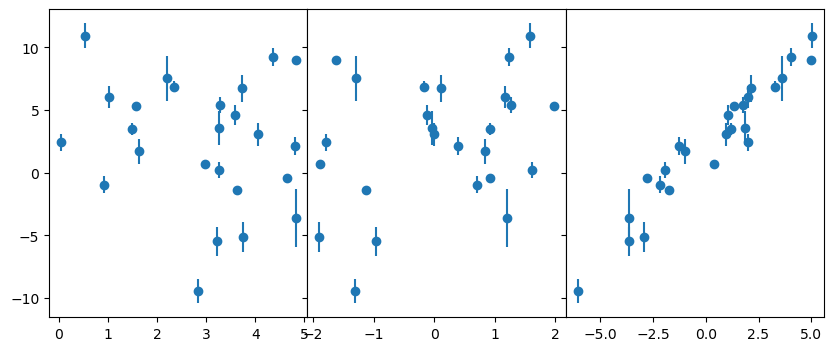

In [28]:
# Let's make some use of matrix and vector data types in an example regression with three covariates x1, x2, and x3.
# We will be using QR decomposition, and here K=3!
import stan
from scipy.stats import uniform, norm
from corner import corner
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(12345)

sigma = 1. # error scale
alpha = 0.5 # slope
beta = np.asarray([0.5, 1., 1.5]) # coefficent vector
n = 25

x1_dist = uniform(loc=0., scale=5.)
x2_dist = uniform(loc=-2., scale=4.)
x3_dist = norm(loc=1., scale=3.) # mixing it up a bit...
err_dist = norm(0., sigma)

x1 = x1_dist.rvs(size=n)
x2 = x2_dist.rvs(size=n)
x3 = x3_dist.rvs(size=n)
y_err = err_dist.rvs(size=n)

X = np.vstack((x1, x2, x3)).T
y = np.dot(X, beta) + alpha + y_err 

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4), sharey=True, gridspec_kw={'wspace': 0.0})
ax1.errorbar(x1, y, yerr=y_err, ls='', marker='o')
ax2.errorbar(x2, y, yerr=y_err, ls='', marker='o')
ax3.errorbar(x3, y, yerr=y_err, ls='', marker='o')
plt.show()


In [29]:
# Load up our qr_linearmodel.stan script:
import nest_asyncio
nest_asyncio.apply()

with open('qr_linearmodel.stan', 'r') as f:
    qr_script = f.read()

data = {
    'N': n,
    'K': 3,
    'X': X,
    'y': y
}

qr_model = stan.model.build(qr_script, data=data)

Building...

In file included from /Users/jaredhand/Library/Caches/httpstan/4.8.2/models/22y7yunr/model_22y7yunr.cpp:2:
In file included from /Users/jaredhand/opt/miniconda3/envs/stan_workshop/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/jaredhand/opt/miniconda3/envs/stan_workshop/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/jaredhand/opt/miniconda3/envs/stan_workshop/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/jaredhand/opt/miniconda3/envs/stan_workshop/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:26:
/Users/jaredhand/opt/miniconda3/envs/stan_workshop/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/beta.hpp:70:32: warning: lambda capture 'b' is not used [-Wunused-lambda-capture]
                           [a, b, digamma_ab](auto& vi) mutable {
                             ~~^
In file included from /Users/

10 warnings generated.
ld: warning: direct access in function 'long double boost::math::detail::bessel_j0<long double>(long double)' from file '/Users/jaredhand/opt/miniconda3/envs/stan_workshop/lib/python3.9/site-packages/httpstan/stan_services.o' to global weak symbol 'long double boost::math::detail::bessel_j0<long double>(long double)::Q2' from file 'build/temp.macosx-10.9-x86_64-cpython-39/Users/jaredhand/Library/Caches/httpstan/4.8.2/models/22y7yunr/model_22y7yunr.o' means the weak symbol cannot be overridden at runtime. This was likely caused by different translation units being compiled with different visibility settings.
ld: warning: direct access in function 'long double boost::math::detail::bessel_j0<long double>(long double)' from file '/Users/jaredhand/opt/miniconda3/envs/stan_workshop/lib/python3.9/site-packages/httpstan/stan_services.o' to global weak symbol 'long double boost::math::detail::bessel_j0<long double>(long double)::P2' from file 'build/temp.macosx-10.9-x86_6

In [30]:
# Sample the posterior:
num_samples = 4000
num_chains = 8

qr_fit = qr_model.sample(num_samples=num_samples, num_chains=num_chains)


Sampling:   0%
Sampling:  12% (5000/40000)
Sampling:  25% (10000/40000)
Sampling:  38% (15000/40000)
Sampling:  50% (20000/40000)
Sampling:  62% (25000/40000)
Sampling:  75% (30000/40000)
Sampling:  88% (35000/40000)
Sampling: 100% (40000/40000)
Sampling: 100% (40000/40000), done.
Messages received during sampling:
  Gradient evaluation took 0.001668 seconds
  1000 transitions using 10 leapfrog steps per transition would take 16.68 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.001645 seconds
  1000 transitions using 10 leapfrog steps per transition would take 16.45 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.001635 seconds
  1000 transitions using 10 leapfrog steps per transition would take 16.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.001707 seconds
  1000 transitions using 10 leapfrog steps per transition would take 17.07 seconds.
  Adjust your expectations accordingly!
  Gradient 

alpha mean, std: 1.3090561382835617 0.43464033937492713
sigma mean, std: 0.5686099484079791 0.16665758814773093


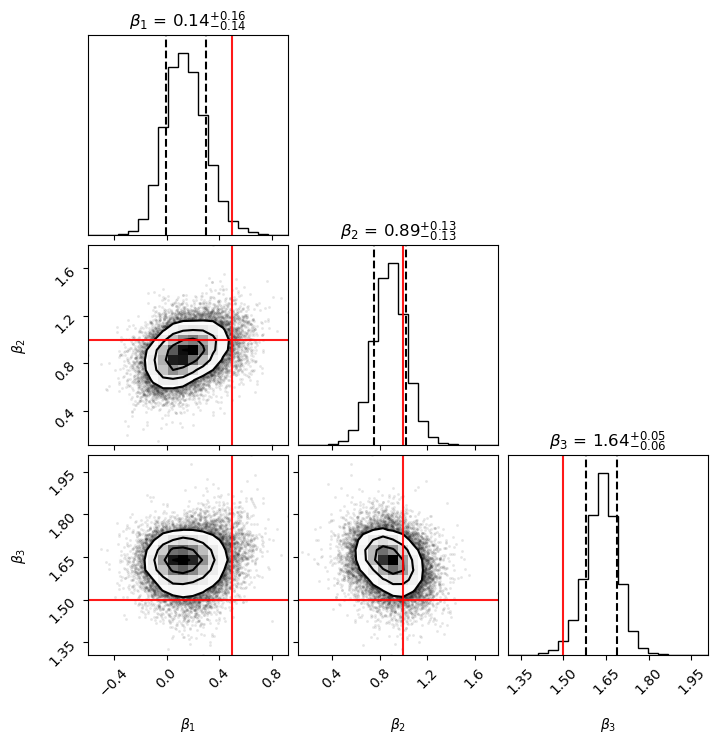

In [31]:
# Look at the results!
beta_corner_sample = qr_fit['beta']

beta_figure = corner(
    beta_corner_sample.T,
    labels=[
        r'$\beta_1$',
        r'$\beta_2$',
        r'$\beta_3$'
    ],
    quantiles=[0.16, 0.84],
    show_titles=True,
    title_kwargs={'fontsize': 12},
)
beta_figure.axes[0].axvline(beta[0], color='red', alpha=0.9)
beta_figure.axes[3].axvline(beta[0], color='red', alpha=0.9)
beta_figure.axes[3].axhline(beta[1], color='red', alpha=0.9)
beta_figure.axes[6].axvline(beta[0], color='red', alpha=0.9)
beta_figure.axes[6].axhline(beta[2], color='red', alpha=0.9)
beta_figure.axes[4].axvline(beta[1], color='red', alpha=0.9)
beta_figure.axes[7].axvline(beta[1], color='red', alpha=0.9)
beta_figure.axes[7].axhline(beta[2], color='red', alpha=0.9)
beta_figure.axes[8].axvline(beta[2], color='red', alpha=0.9)

print('alpha mean, std:', np.mean(qr_fit['alpha']), np.std(qr_fit['alpha']))
print('sigma mean, std:', np.mean(qr_fit['sigma']), np.std(qr_fit['sigma']))


You can also broadcast some operations. If you want element-wise versions of an operator such as "\*", then you place a period right before it ".\*" 

Another useful operation is the transpose operator:
```stan
vector[N] v;
row_vector[N] v_row;

v_row = v'; // ' operator outputs the transpose of vector v
```

Here are some examples of valid linear algebra or element-wise operations:

```stan
vector[N] v;
vector[N] u;
real vu;
vector[N] w;

vu = v * u; // fails... u would need to be a row vector for this to work
vu = v * u'; // works because we first transpose u to be a row vector

// Some valid element-wise operations:
w = v .* u;
w = v ./ u;
```